# Time Series Forecasting of Cryptocurrencies

# imports

In [1]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.2 MB/s eta 0:00:00


In [2]:
# analysis
import pandas as pd
import numpy as np
import glob

# # define random seed of numpy
seed_value = 42
np.random.seed(seed_value)

# plot
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as plx
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [16, 4]

# # progress
import traceback
from tqdm import tqdm
tqdm.pandas(desc="Processing Rows")

# # output
import warnings
warnings.filterwarnings('ignore')

# # forecast
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# # expand display output
pd.set_option('display.max_columns', None)

# ENGINEERING

Lendo todos os arquivos da pasta ``raw_data``, e armazenando um arquivo concatenado identificando cada dataset pelo ticker do criptoativo

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")

# Dicionário para armazenar os DataFrames tratados
data_frames = {}

for file_name in file_names:
    # Obtendo o nome do arquivo sem a extensão
    name = file_name.split('/')[-1].split('.')[0]

    # Lendo o arquivo CSV e aplicando os tratamentos
    df = pd.read_csv(file_name, sep=';')
    cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
    cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
    df = df[cols_to_keep].rename(columns=cols_to_rename)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Extrair o ticker da parte inicial do nome da chave
    ticker = name.split('_')[0]

    # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
    df['ticker'] = ticker

    # Armazenando o DataFrame tratado no dicionário
    data_frames[name] = df

# Acesse cada DataFrame usando seus nomes de arquivo como chaves, por exemplo:
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [5]:
data_frames['BTC_All_graph_coinmarketcap']

,close,volume,market_cap,ticker
date,,,,
2013-04-01 00:00:00+00:00,278.528200,0.000000e+00,3.118457e+09,BTC
2013-05-01 00:00:00+00:00,276.292200,0.000000e+00,2.901242e+09,BTC
2013-06-01 00:00:00+00:00,215.594137,0.000000e+00,2.349464e+09,BTC
2013-07-01 00:00:00+00:00,241.503268,0.000000e+00,2.719703e+09,BTC
2013-08-01 00:00:00+00:00,322.417250,0.000000e+00,3.584583e+09,BTC
...,...,...,...,...
2023-08-01 00:00:00+00:00,128500.820776,2.068772e+12,2.386531e+12,BTC
2023-09-01 00:00:00+00:00,135716.038785,1.673128e+12,2.605974e+12,BTC
2023-10-01 00:00:00+00:00,174590.403638,2.397612e+12,3.407242e+12,BTC


In [6]:
# concatenando
df = pd.DataFrame()

# Concatenar todos os DataFrames no dicionário
for key, value in data_frames.items():
    df = pd.concat([df, value])

# dropando possiveis duplicidades do df 1M
df = df.drop_duplicates()
df

,close,volume,market_cap,ticker
date,,,,
2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH
2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH
2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH
2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH
2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH
...,...,...,...,...
2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC
2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC
2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC


In [7]:
# SAVE SILVER
#silver_path = glob.glob('../silver/')
silver_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
filename = "df_silver.parquet"
silver_save_path = silver_save_path + filename

df.to_parquet(silver_save_path)

In [8]:
# format date
df_month = df.reset_index().copy()
df_month['month'] = df_month['date'].dt.to_period('M').dt.to_timestamp()

#df_month

In [9]:
# df_month[df_month["ticker"] == "BCH"].sort_values(by="month").tail(20)

In [10]:
df_month_mean = df_month.groupby(["month",  "ticker"]).agg(
    close_mean = ("close", "mean"),
    volume_mean = ("volume", "mean"),
    market_cap_mean = ("market_cap", "mean")
).reset_index()

In [11]:
# df_month_mean[df_month_mean["month"] == "2024-01-01"] #.sort_values(by="month").tail(20)

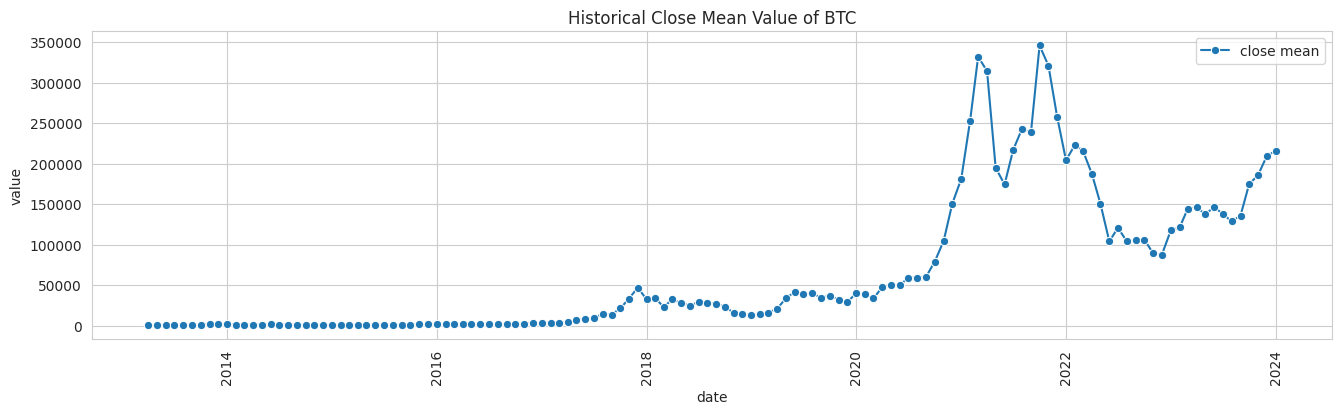

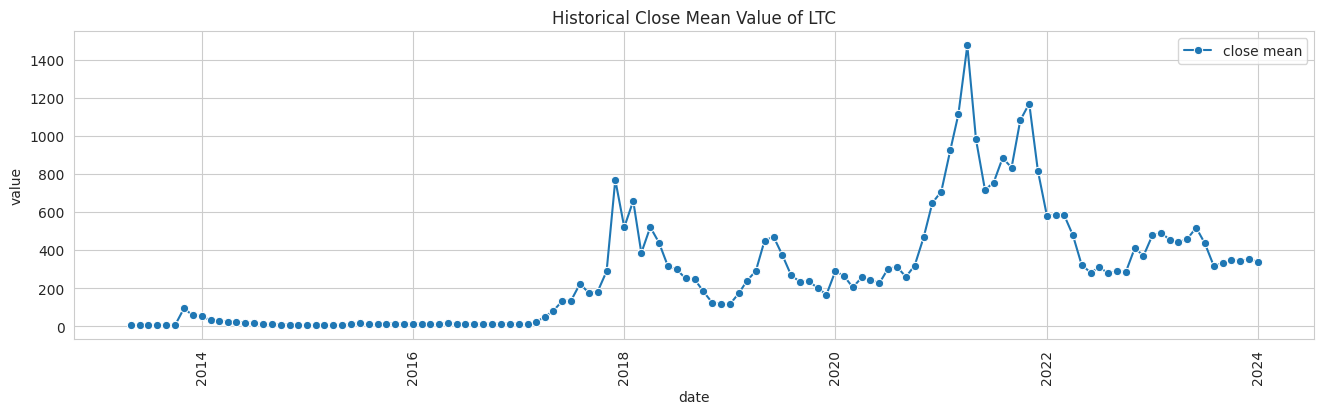

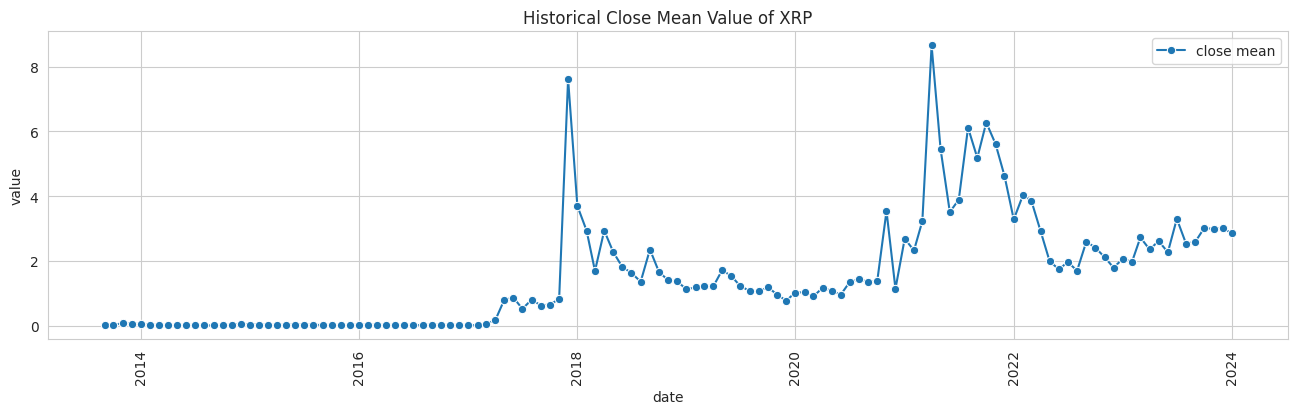

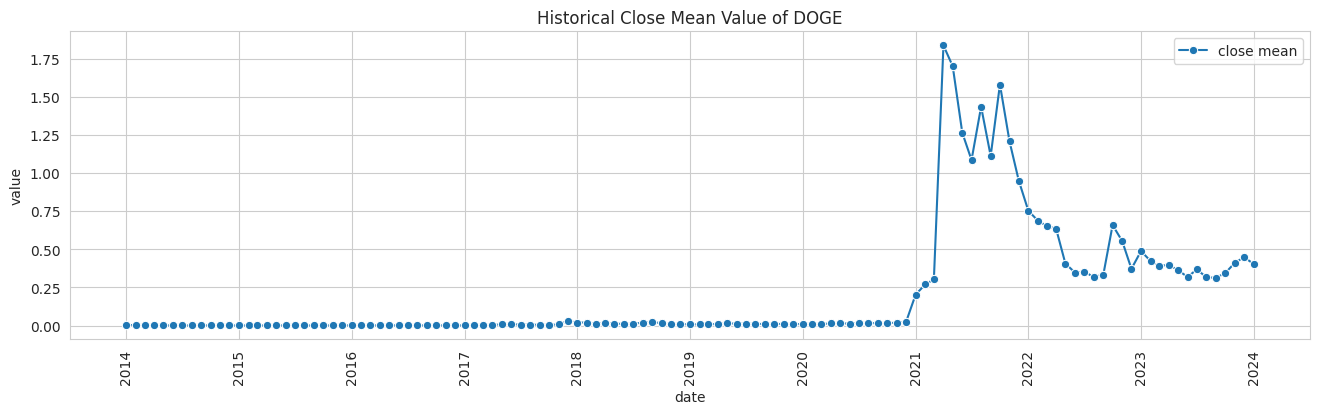

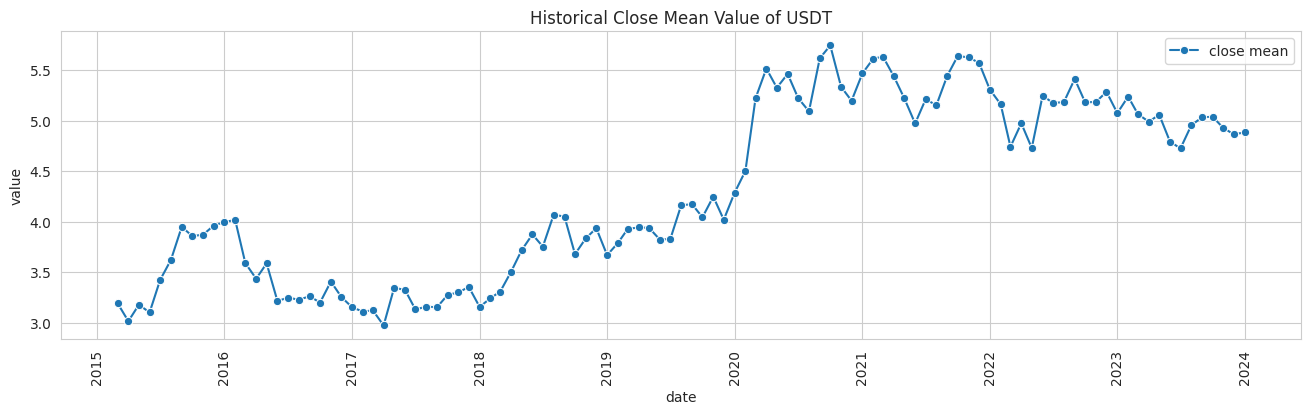

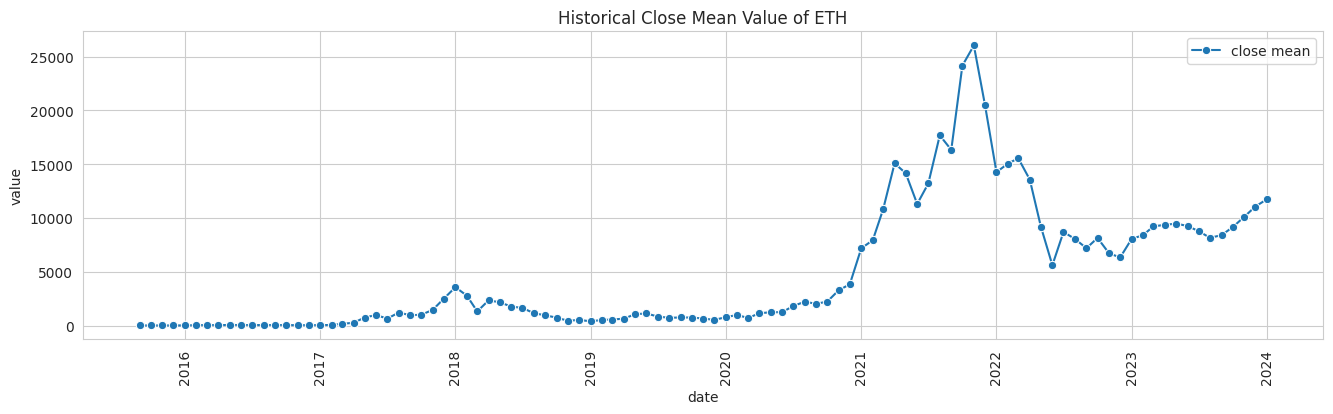

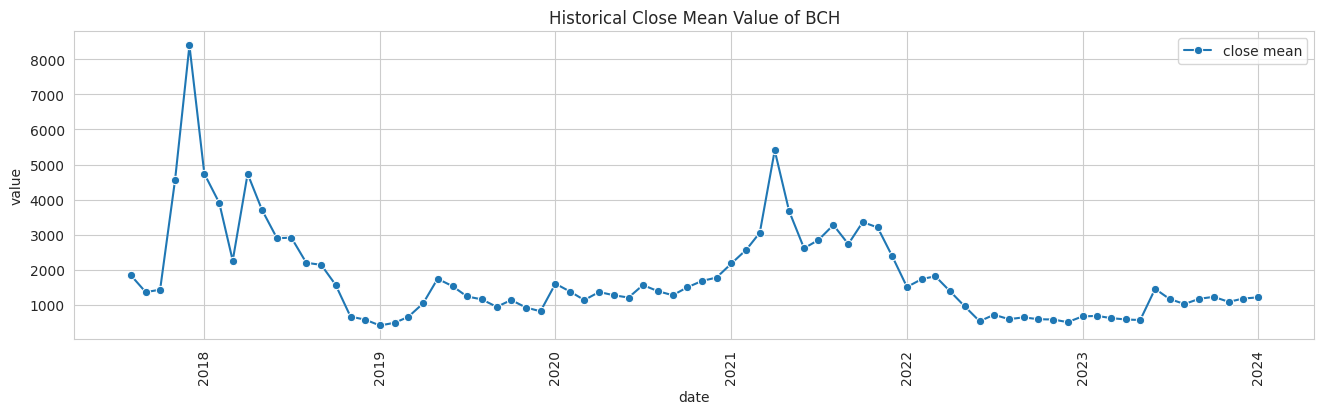

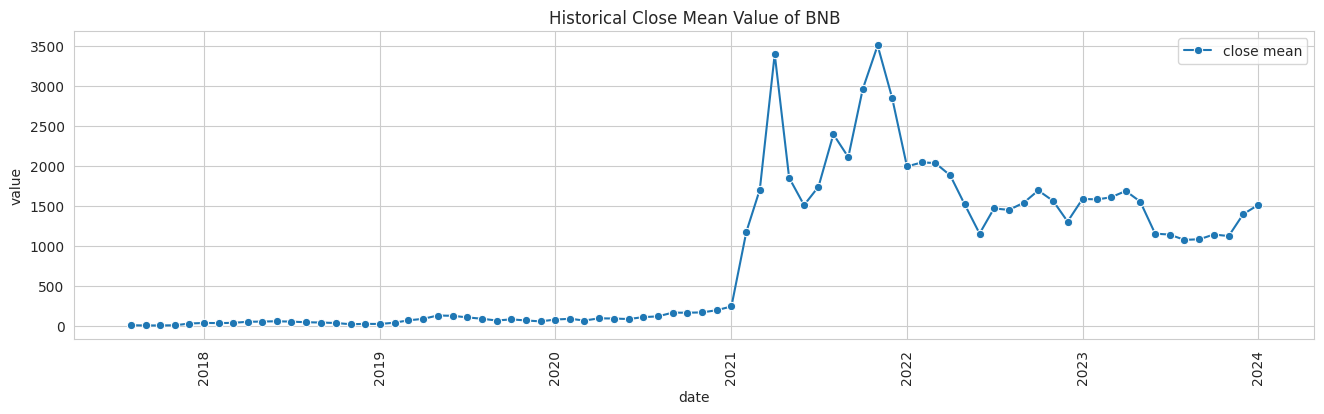

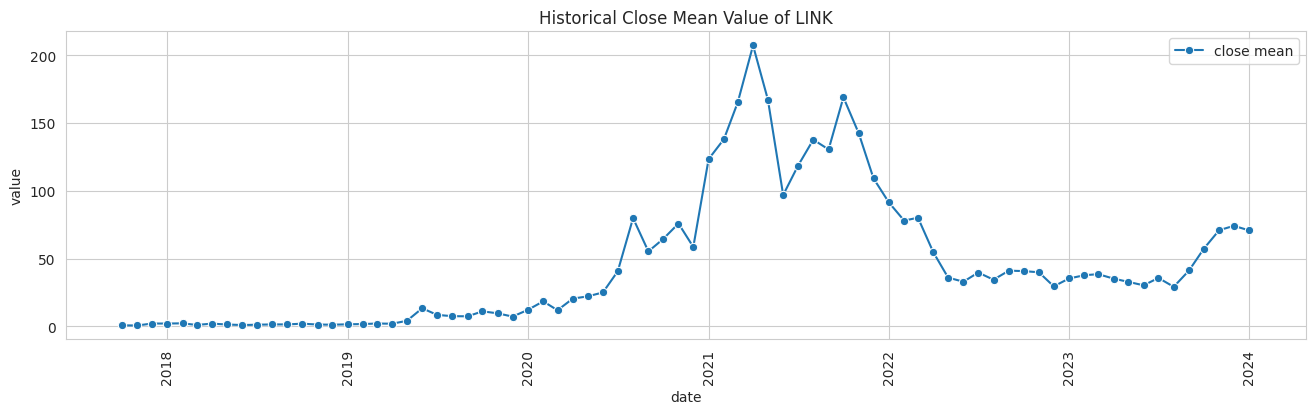

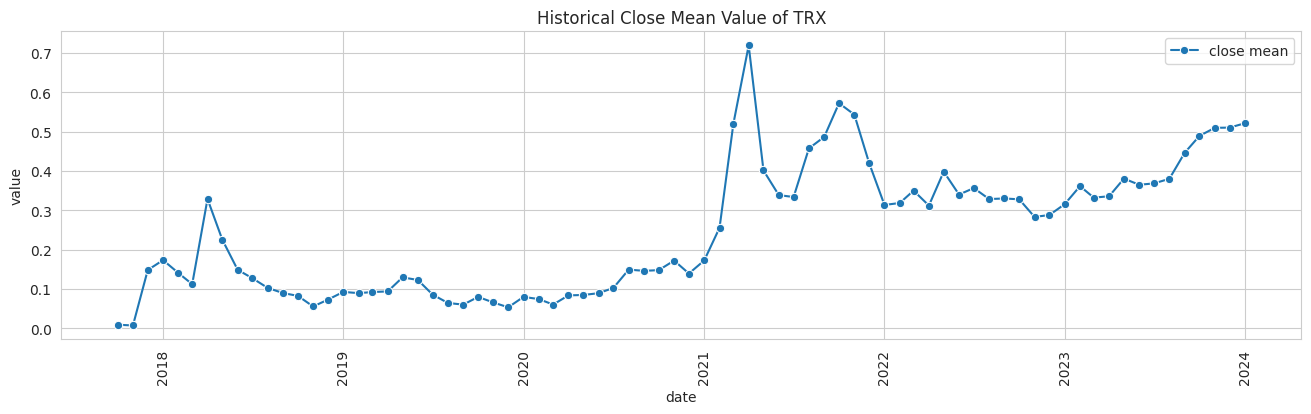

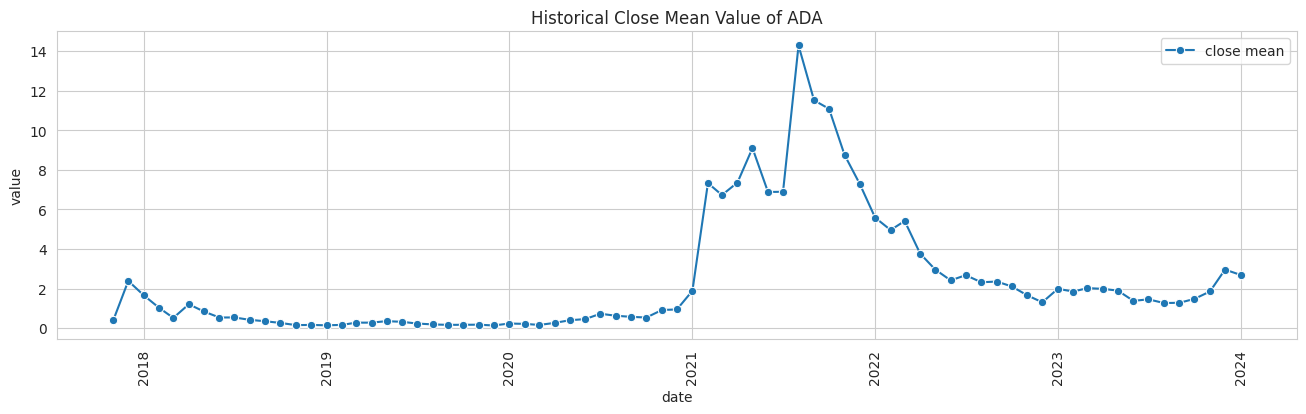

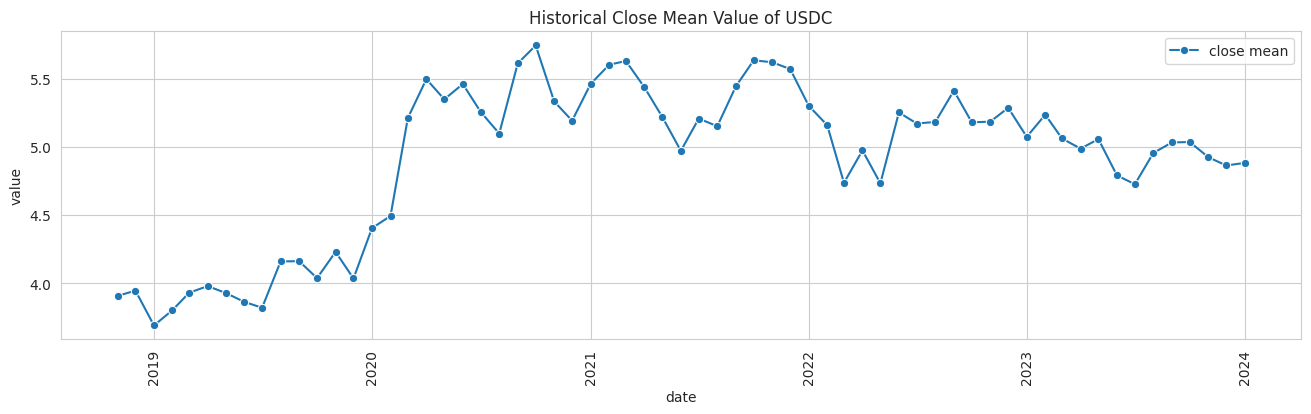

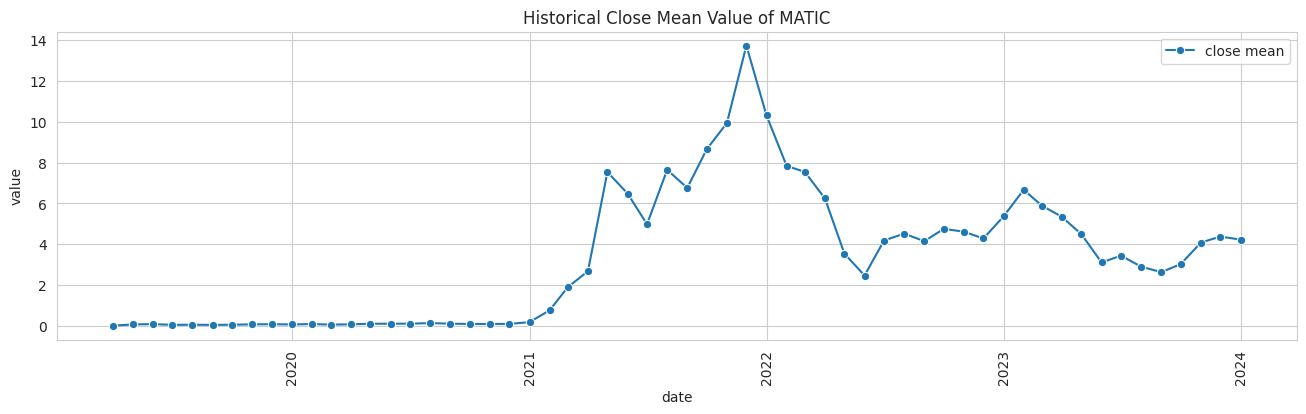

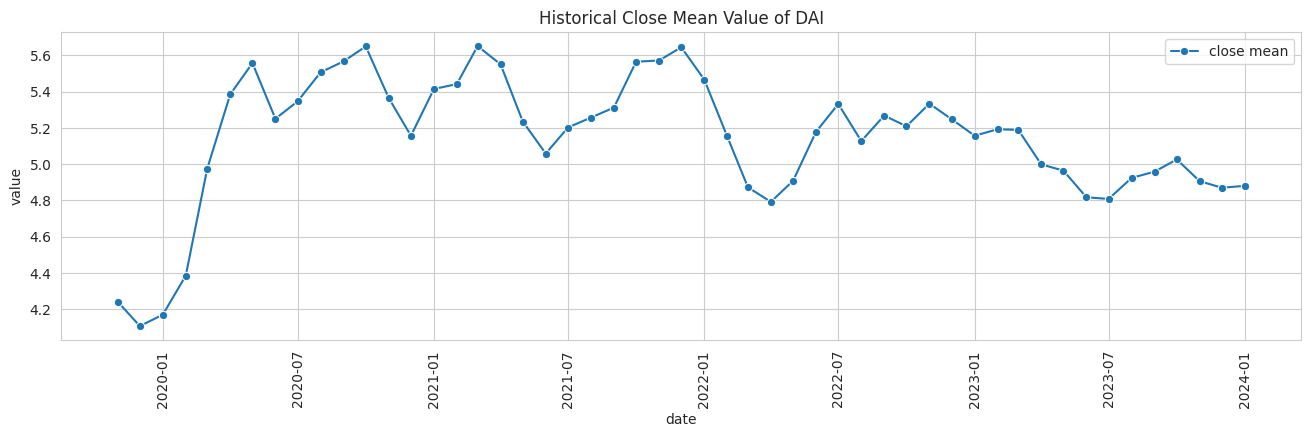

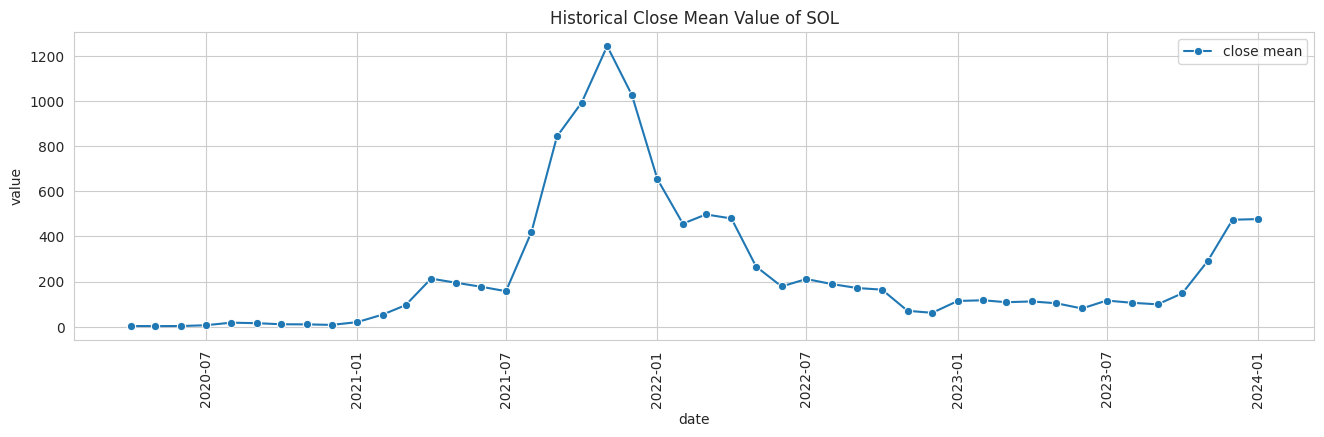

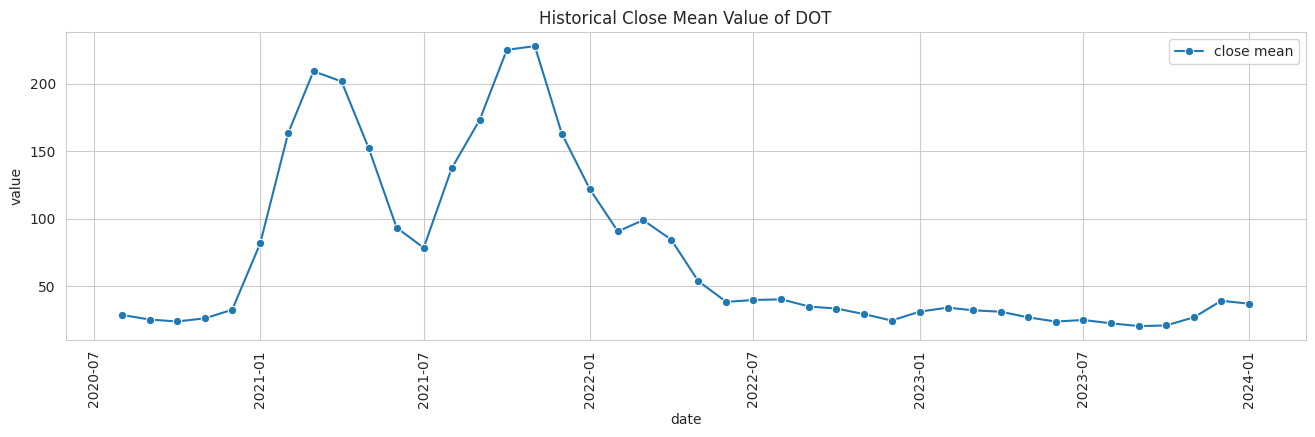

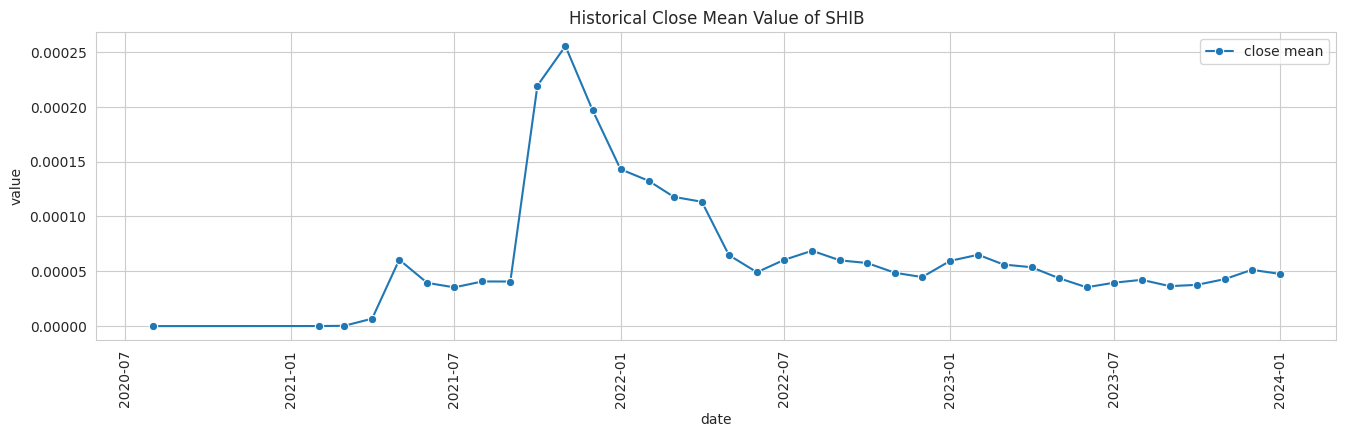

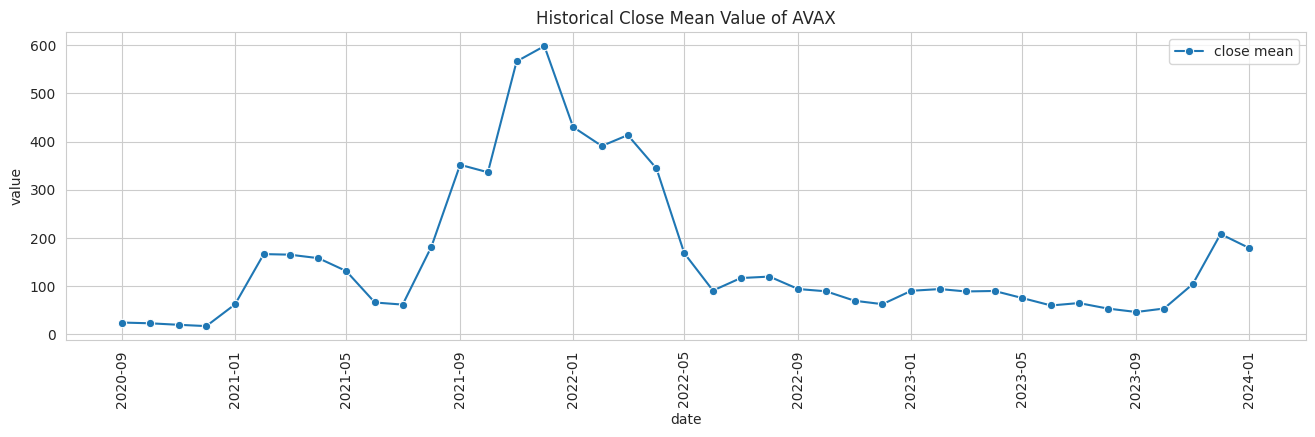

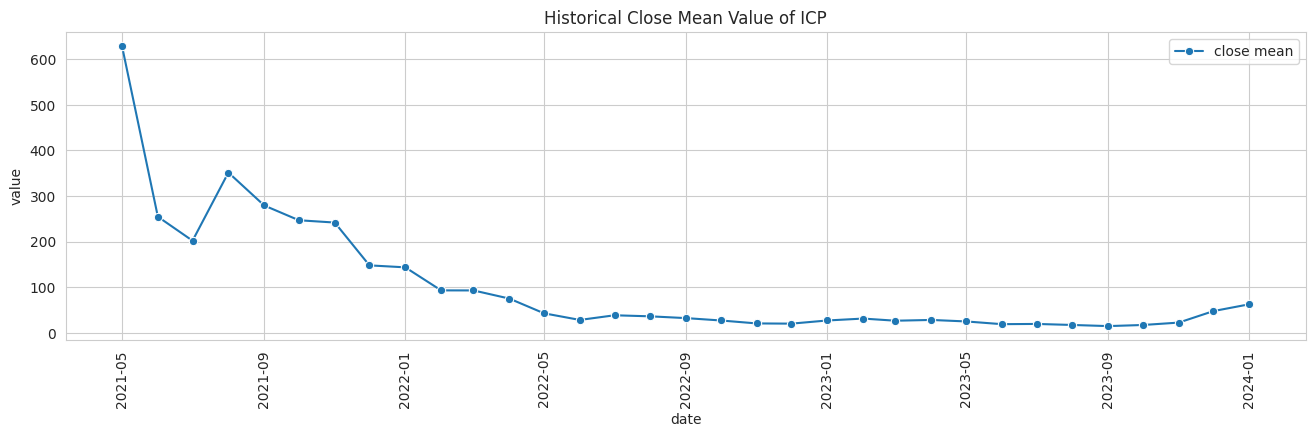

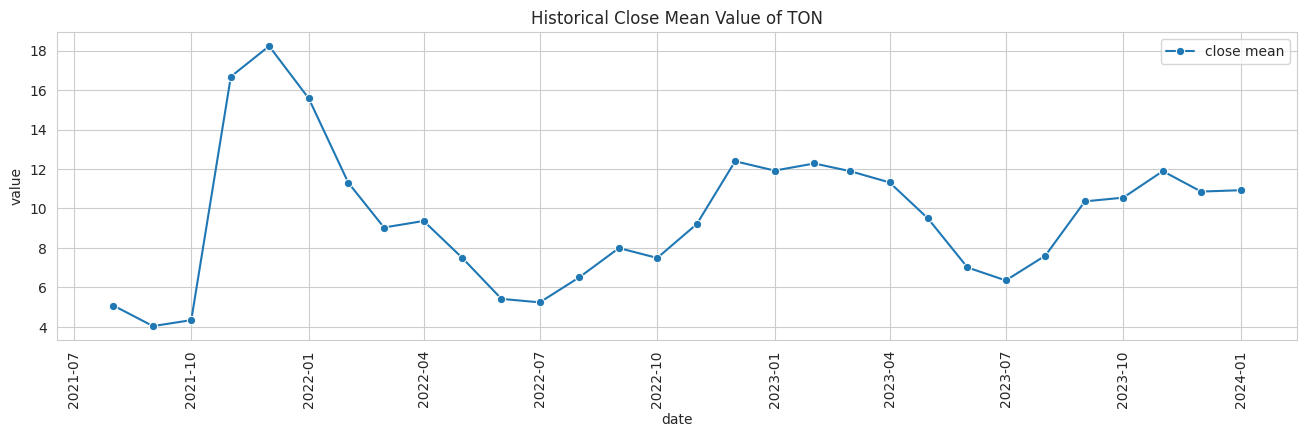

In [12]:
df_month_mean['close_mean_log'] = np.log(df_month_mean['close_mean'] + 1)  # Adicionando 1 para evitar log(0)

for tk in df_month_mean["ticker"].unique():
  db_temp = df_month_mean[df_month_mean["ticker"] == tk]

  # Plotando o histórico
  sns.lineplot(x='month', y='close_mean', data=db_temp, label='close mean', marker='o')

  # Configurando o título e os rótulos dos eixos
  plt.title(f'Historical Close Mean Value of {tk}')
  plt.xlabel('date')
  plt.ylabel('value')

  # Girando os rótulos dos meses em 90 graus
  plt.xticks(rotation=90)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

In [13]:
# pivotando para colunas para usar as demais como features
df_month_mean_pivot = df_month_mean.pivot_table(index='month', columns='ticker', values='close_mean')
df_month_mean_pivot.columns = df_month_mean_pivot.columns.astype(str) # tornando todos os nomes string
df_month_mean_pivot = df_month_mean_pivot.fillna(0)
df_month_mean_pivot.columns.name = None # removendo o nome da tabela que apareceria como colune
df_month_mean_pivot = df_month_mean_pivot.reset_index()
df_month_mean_pivot

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213


In [14]:
# SAVE SILVER
#gold_path = glob.glob('../gold/')
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "df_gold.parquet"
gold_save_path = gold_save_path + filename

df_month_mean_pivot.to_parquet(gold_save_path)

# ANALYSIS

- [X] Previsão Univariada
- [X] Previsão Multivariada
- [X] Previsão com modelos de Bagging e Boosting
- [ ] Geração de dados sintéticos para previsão com bagging/boosting
- [ ] Automatização de tudo

## Previsão Univariada

In [15]:
df = pd.read_parquet(gold_save_path)
df.set_index("month", inplace=True)
df.head()

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.0,0.0,0.0,0.0,278.528200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,276.292200,0.0,0.0,0.0,0.0,0.0,0.0,6.332617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,215.594137,0.0,0.0,0.0,0.0,0.0,0.0,6.651075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,241.503268,0.0,0.0,0.0,0.0,0.0,0.0,6.530263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,322.417250,0.0,0.0,0.0,0.0,0.0,0.0,6.154942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
target = "BTC"

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2565.750, Time=1.92 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2831.665, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2590.806, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2739.718, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2832.898, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=2565.613, Time=0.85 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=2591.253, Time=0.47 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=2565.386, Time=1.65 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=2567.373, Time=3.52 sec
 ARIMA(2,0,2)(0,1,3)[12] intercept   : AIC=2567.386, Time=4.79 sec
 ARIMA(2,0,2)(1,1,3)[12] intercept   : AIC=2568.901, Time=5.02 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=2568.513, Time=0.94 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=2566.733, Time=0.86 sec
 ARIMA(3,0,2)(0,1,2)[12] intercept   : AIC=2562.495, Time=2.63 sec
 ARIMA(3,0,2)(0,1,1

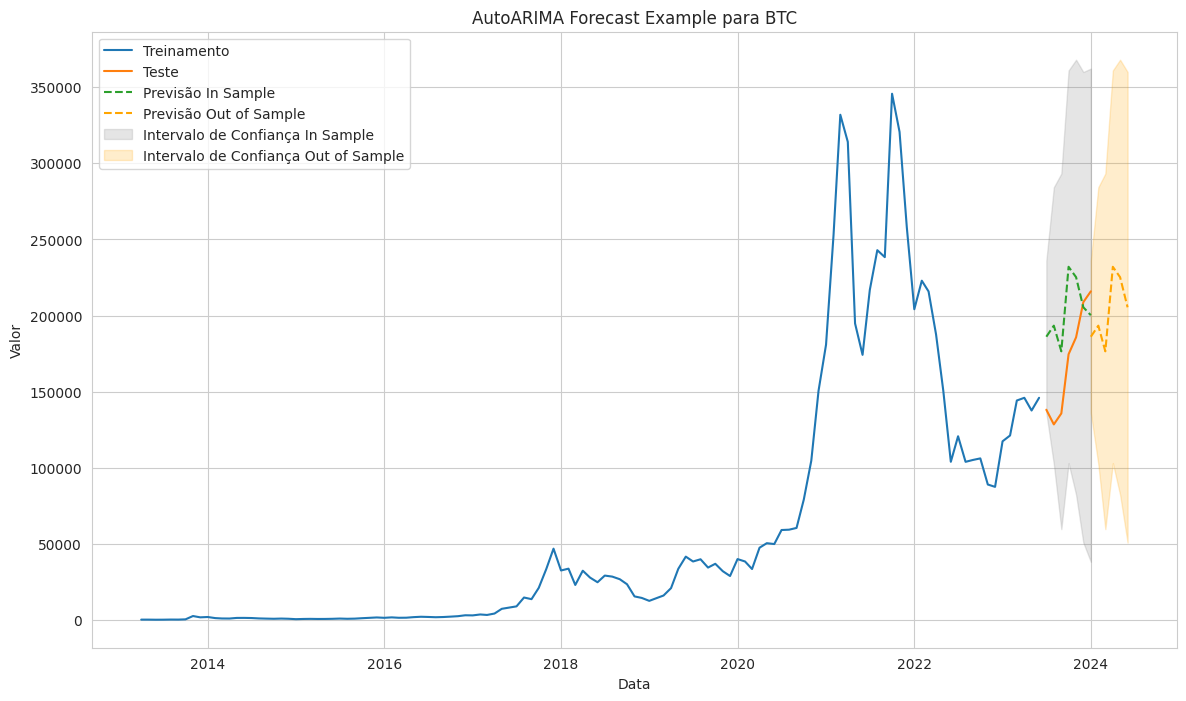

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# Seu código para preparar os dados
#target = "ETH"
df_uni = df[df[target] > 0][[target]].copy()

# Dividir os dados em treinamento e teste
train_size = int(len(df_uni) * 0.95)
train, test = df_uni[:train_size], df_uni[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values,
                   seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                   information_criterion='aic',
                   trace=True, error_action='ignore', stepwise=True)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test), return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample, return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [18]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarima = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarima:.2f}%")

MAPE In Sample: 25.47%


## Previsão Multivariada

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2565.750, Time=1.75 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2831.665, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2590.806, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2739.718, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2832.898, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=2565.613, Time=0.84 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=2591.253, Time=0.44 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=2565.386, Time=1.58 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=2567.373, Time=2.17 sec
 ARIMA(2,0,2)(0,1,3)[12] intercept   : AIC=2567.386, Time=5.19 sec
 ARIMA(2,0,2)(1,1,3)[12] intercept   : AIC=2568.901, Time=6.02 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=2568.513, Time=0.92 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=2566.733, Time=0.82 sec
 ARIMA(3,0,2)(0,1,2)[12] intercept   : AIC=2562.495, Time=2.43 sec
 ARIMA(3,0,2)(0,1,1

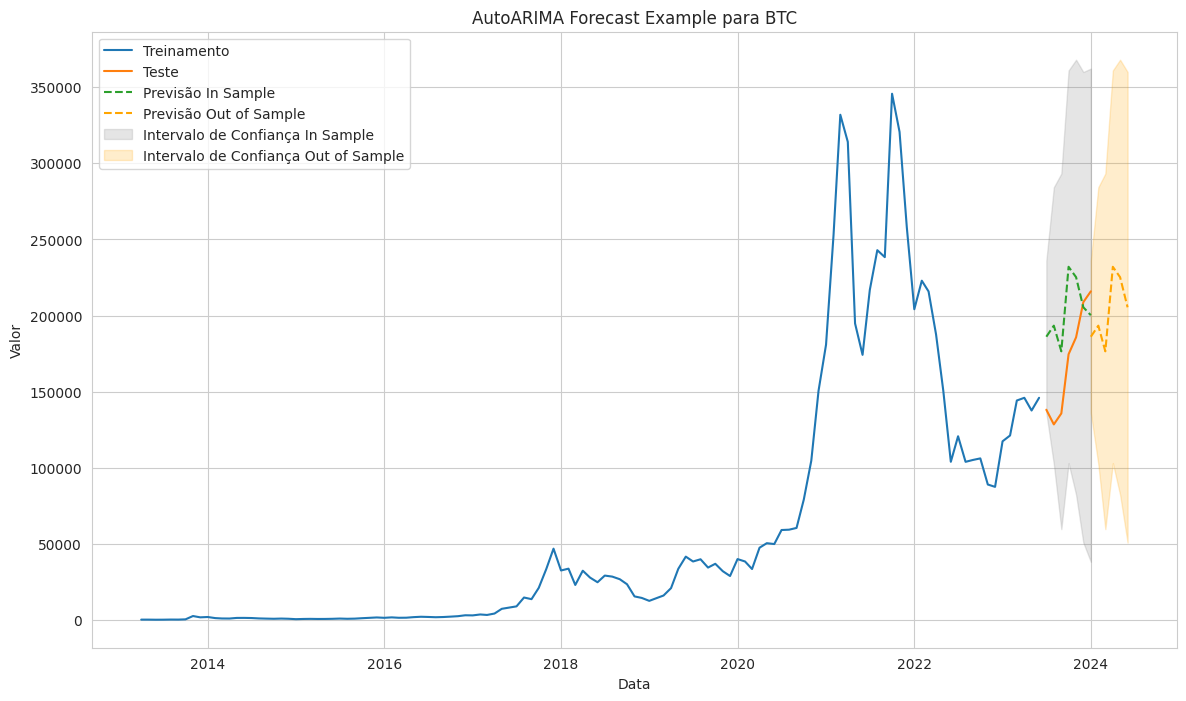

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# target = "ETH"

#exogenous_vars = [col for col in df.columns if col != target]
thresh = 0.8
correlations = df.corrwith(df[target], method="pearson")
exogenous_vars = correlations[(correlations.abs() > thresh)].index
exogenous_vars = exogenous_vars.to_list()
exogenous_vars = [column for column in exogenous_vars if column != target]
exogenous_vars

# Dividir os dados em treinamento e teste
train_size = int(len(df) * 0.95)
train, test = df[:train_size], df[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values,
                   exogenous=train[exogenous_vars].values,
                   seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                   information_criterion='aic',
                   trace=True, error_action='ignore', stepwise=True)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test),
                                                       exogenous=test[exogenous_vars].values,
                                                       return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample,
                                                               exogenous=test.iloc[-1][exogenous_vars].values.reshape(1, -1),
                                                               return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train[target], label='Treinamento')
plt.plot(test[target], label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [20]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarimax = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarimax:.2f}%")

MAPE In Sample: 25.47%


## Bagging e Boosting

In [21]:
random_state = 42
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=random_state)

In [22]:
#target = "ETH"
thresh = 0.9

correlations = df.corrwith(df[target], method="pearson")
high_correlation_columns = correlations[(correlations.abs() > thresh)].index
high_correlation_columns = high_correlation_columns.to_list()
high_correlation_columns = [column for column in high_correlation_columns if column != target]
high_correlation_columns

['BNB', 'DOT', 'ETH', 'LINK', 'TRX']

In [23]:
from sklearn.metrics import mean_absolute_error

df_test = df.reset_index()
df_test

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=3)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

In [24]:
df_test

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP,BTC_RF,BTC_XGB
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777,119519.512162,102050.296875
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081,155628.490765,151510.421875
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949,168061.392092,171954.234375
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213,172703.397089,152781.265625


In [25]:
# Calcular o MAPE
df_test_mm = df_test[[f"{target}", f"{target}_RF", f"{target}_XGB"]].dropna()

actual_values = df_test_mm[target].values
predicted_values_in_sample_rf = df_test_mm[ f"{target}_RF"].values
predicted_values_in_sample_xgb = df_test_mm[ f"{target}_XGB"].values

mape_in_sample_rf = np.mean(np.abs((actual_values - predicted_values_in_sample_rf) / actual_values)) * 100
mape_in_sample_xgb = np.mean(np.abs((actual_values - predicted_values_in_sample_xgb) / actual_values)) * 100

print(f"Target: {target}")
print(f"MAPE In Sample ARIMA: {mape_in_sample_sarima:.2f}%")
print(f"MAPE In Sample SARIMAX: {mape_in_sample_sarimax:.2f}%")
print(f"MAPE In Sample RF: {mape_in_sample_rf:.2f}%")
print(f"MAPE In Sample XGB: {mape_in_sample_xgb:.2f}%")

Target: BTC
MAPE In Sample ARIMA: 25.47%
MAPE In Sample SARIMAX: 25.47%
MAPE In Sample RF: 17.81%
MAPE In Sample XGB: 26.37%


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

df_test = df.reset_index()

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=3)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Inicializando listas para armazenar métricas
metrics_rf_train = []
metrics_rf_test = []
metrics_xgb_train = []
metrics_xgb_test = []

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # MÉTRICAS
    # Métricas no conjunto de treinamento
    train_rmse_rf = mean_squared_error(y_train, random_forest_model.predict(X_train), squared=False)
    train_mape_rf = mean_absolute_error(y_train, random_forest_model.predict(X_train)) / y_train.mean() * 100
    metrics_rf_train.append({'Train_RMSE': train_rmse_rf, 'Train_MAPE': train_mape_rf})

    # Métricas no conjunto de teste
    test_rmse_rf = mean_squared_error(y_test, rf_predictions, squared=False)
    test_mape_rf = mean_absolute_error(y_test, rf_predictions) / y_test.mean() * 100
    metrics_rf_test.append({'Test_RMSE': test_rmse_rf, 'Test_MAPE': test_mape_rf})

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

    # Métricas no conjunto de treinamento
    train_rmse_xgb = mean_squared_error(y_train, xgboost_model.predict(X_train), squared=False)
    train_mape_xgb = mean_absolute_error(y_train, xgboost_model.predict(X_train)) / y_train.mean() * 100
    metrics_xgb_train.append({'Train_RMSE': train_rmse_xgb, 'Train_MAPE': train_mape_xgb})

    # Métricas no conjunto de teste
    test_rmse_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
    test_mape_xgb = mean_absolute_error(y_test, xgb_predictions) / y_test.mean() * 100
    metrics_xgb_test.append({'Test_RMSE': test_rmse_xgb, 'Test_MAPE': test_mape_xgb})

# Criando DataFrames com as métricas
df_metrics_rf_train = pd.DataFrame(metrics_rf_train)
df_metrics_rf_train['Model'] = 'RandomForest'

df_metrics_rf_test = pd.DataFrame(metrics_rf_test)
df_metrics_rf_test['Model'] = 'RandomForest'

df_metrics_xgb_train = pd.DataFrame(metrics_xgb_train)
df_metrics_xgb_train['Model'] = 'XGBoost'

df_metrics_xgb_test = pd.DataFrame(metrics_xgb_test)
df_metrics_xgb_test['Model'] = 'XGBoost'

# # Juntando os DataFrames em um único DataFrame
# df_all_metrics = pd.concat([df_metrics_rf_train, df_metrics_rf_test, df_metrics_xgb_train, df_metrics_xgb_test], ignore_index=True)

# # Exibindo o DataFrame combinado
# print("Métricas para RandomForest (Treino e Teste) e XGBoost (Treino e Teste):")
# df_all_metrics

In [36]:
# Criando DataFrames com as métricas
df_metrics_rf_train = pd.DataFrame(metrics_rf_train)
df_metrics_rf_train['Model'] = 'RandomForest'
df_metrics_rf_test = pd.DataFrame(metrics_rf_test)
df_metrics_rf_test['Model'] = 'RandomForest'
df_metrics_xgb_train = pd.DataFrame(metrics_xgb_train)
df_metrics_xgb_train['Model'] = 'XGBoost'
df_metrics_xgb_test = pd.DataFrame(metrics_xgb_test)
df_metrics_xgb_test['Model'] = 'XGBoost'

# Juntando os DataFrames em um único DataFrame
df_all_metrics = pd.concat([df_metrics_rf_train, df_metrics_rf_test, df_metrics_xgb_train, df_metrics_xgb_test],  axis=0, ignore_index=True)
df_all_metrics

# Agrupando as métricas pelo índice (representando o split) e modelo
# df_grouped_metrics = df_all_metrics.groupby(['Model', df_all_metrics.index])[['Train_RMSE', 'Train_MAPE', 'Test_RMSE', 'Test_MAPE']].mean().reset_index()

# # Exibindo o DataFrame agrupado
# print("Métricas agrupadas para RandomForest (Treino e Teste) e XGBoost (Treino e Teste):")
# df_grouped_metrics

,Train_RMSE,Train_MAPE,Model,Test_RMSE,Test_MAPE
0,5451.633518,4.420788,RandomForest,NaN,NaN
1,5587.484290,4.697163,RandomForest,NaN,NaN
2,5437.392039,4.518237,RandomForest,NaN,NaN
3,NaN,NaN,RandomForest,35860.882731,25.010204
4,NaN,NaN,RandomForest,18823.539647,12.798491
5,NaN,NaN,RandomForest,33655.022238,15.723503
6,268.355429,0.171842,XGBoost,NaN,NaN
7,265.182968,0.165631,XGBoost,NaN,NaN
8,261.979474,0.155221,XGBoost,NaN,NaN
9,NaN,NaN,XGBoost,49452.308165,35.087366


In [28]:
df_metrics_rf_train #.merge(df_metrics_rf_test) #, on="Model", ignore_index=True)

,Train_RMSE,Train_MAPE,Model
0,5451.633518,4.420788,RandomForest
1,5587.484290,4.697163,RandomForest
2,5437.392039,4.518237,RandomForest


In [29]:
df_metrics_rf_test

,Test_RMSE,Test_MAPE,Model
0,35860.882731,25.010204,RandomForest
1,18823.539647,12.798491,RandomForest
2,33655.022238,15.723503,RandomForest


# OUT OF SAMPLE FORECAST

In [30]:
# GERAÇÃO DE DADOS SINTÉTICOS

In [31]:
# PREVISÃO